In [781]:
import pandas as pd
import dataparser  # Подключаем необходимые библиотеки
from math import log
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from dataparser import *

import folium
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)

# Читаем данные из файла '_data.csv' и указываем второй столбец (индексация с 0) в качестве индекса
data = pd.read_csv('_data.csv', index_col=1)

# Отфильтровываем записи, оставляя только те, где цена указана в рублях
# Это делается для избежания неопределенности при смешивании цен в разных валютах
data = data[data['Цена'].str.contains('руб.')].reset_index()

# Оставляем только записи, относящиеся к Москве
data = data[data['Адрес'].str.contains('Москва')].reset_index()

# Заполняем пропущенные значения в столбце 'Количество комнат' значением 1,
# так как предполагаем, что это студии или однокомнатные квартиры
# Удаляем столбец 'Тип', так как он имеет одинаковые значения для всех записей
data = data.fillna({'Количество комнат': 1}).drop('Тип', axis=1)


In [782]:
def get_col_room(data):
    # Функция для извлечения количества комнат
    # Преобразуем значения в столбце 'Количество комнат' в строки и берем первый символ,
    # предполагая, что это число комнат. Затем преобразуем в целое число.
    return data['Количество комнат'].astype(str).apply(lambda x: int(x[0]))

# Создаем новый столбец 'col_rooms' и заполняем его значениями, полученными из функции get_col_room
data['col_rooms'] = get_col_room(data)


In [783]:
def get_price(data):
    # Функция для извлечения цены
    # Используем функцию splbac (она возвращает подстроку между 'руб./' и первым пробелом),
    # преобразуем результат в число с плавающей запятой и затем в целое число.
    return data['Цена'].apply(lambda x: int(float(splbac(x, 'руб./')[0])))

# Создаем новый столбец 'price' и заполняем его значениями, полученными из функции get_price
data['price'] = get_price(data)


In [784]:
def get_ceiling_height(data):
    # Функция для извлечения высоты потолков
    # Преобразуем значения в столбце 'Высота потолков, м' в строки, разбиваем по пробелам
    return data['Высота потолков, м'].astype(str).apply(lambda x: float(x.split()[0]))


# Создаем новый столбец 'ceiling_height' и заполняем его значениями, полученными из функции get_ceiling_height
data['ceiling_height'] = get_ceiling_height(data)


In [785]:
# Фильтруем данные, оставляя только те записи, где высота потолков меньше 7 метров или значение неизвестно (NaN)
data = data[(data['ceiling_height'] < 7) | (np.isnan(data['ceiling_height']))]

# Выводим отфильтрованные данные
data.head()


,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000,3.0
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000,3.5
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000,3.2
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000,3.2
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000,3.9


In [786]:
# Заполняем пропущенные значения в столбце 'ceiling_height' средним значением
# Округляем результат до одного знака после запятой
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].mean()).round(1)

# Выводим обновленные данные
data


,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.00,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000,3.0
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.50,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000,3.5
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.20,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000,3.2
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.20,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000,3.2
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.90,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19709,23339,215565511,23363,1,м. Говорово (8 мин пешком),"Москва, Боровское шоссе, 2к7, ш. Боровское (3 ...",35.0/16.4/8.0,10/14,NaN,"42000.0 руб./ За месяц, Залог - 42000 руб., Ко...",+79154383401,Сдаётся светлая теплая квартира (студия) с бал...,Евроремонт,NaN,Балкон (1),NaN,Совмещенный (1),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Сти...",Мещерский лес,NaN,NaN,"Пасс (1), Груз (1)",NaN,https://www.cian.ru/rent/flat/215565511,1,42000,2.8
19710,23340,274654844,23364,1,м. Солнцево (7 мин пешком),"Москва, Производственная улица, 8к1, ш. Боровс...",38.7/16.5/11.0,"5/18, Монолитный",NaN,"45000.0 руб./ За месяц, Залог - 45000 руб., Ко...",+79151173402,Сдам однокомнатную квартиру на длительный срок...,Евроремонт,NaN,Лоджия (1),Во двор,Совмещенный (1),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Сти...",Лучи,NaN,NaN,"Пасс (1), Груз (1)",NaN,https://www.cian.ru/rent/flat/274654844,1,45000,2.8
19711,23341,268679909,23365,"2, Оба варианта",м. Солнцево (6 мин пешком),"Москва, Боровский проезд, 11",43.1,"5/5, Кирпичный",NaN,"50000.0 руб./ За месяц, Залог - 50000 руб., Ко...",+79653825192,Рассматриваются квартиранты только славяне и т...,Дизайнерский,NaN,Балкон (1),На улицу и двор,Совмещенный (1),Можно с детьми,"Мебель на кухне, Душевая каби

In [787]:
data['ceiling_height'].describe()

count    19696.000000
mean         2.768207
std          0.206575
min          1.200000
25%          2.600000
50%          2.800000
75%          2.800000
max          6.000000
Name: ceiling_height, dtype: float64

In [788]:
def get_metro_lamb(s):
    # Вспомогательная функция для извлечения названия метро
    # Используем splfb для извлечения подстроки между 'м.' и первой открывающейся скобкой '('
    # Удаляем лишние пробелы в начале и конце строки
    return splfb(s, 'м.', '(').strip() if s is not None else None

def get_metro(data):
    # Функция для извлечения названия метро
    # Применяем вспомогательную функцию get_metro_lamb к столбцу 'Метро'
    return data['Метро'].astype(str).apply(get_metro_lamb)

# Создаем новый столбец 'metro' и заполняем его значениями
data['metro'] = get_metro(data)

In [789]:
def get_metro_time_lamb(s):
    # Вспомогательная функция для извлечения времени до метро
    try:
        if 'пешком' in s:
            # Если в строке содержится 'пешком', извлекаем значение метро пешком
            return float(splfb(s, '(', ' мин').strip()) if 'None' not in s else 0
        else:
            # Если не указано 'пешком', предполагаем, что это время на транспорте (умножаем на 3 для преобразования)
            return float(splfb(s, '(', ' мин').strip()) * 3 if 'None' not in s else 0
    except:
        pass

def get_metro_time(data):
    # Функция для извлечения времени до метро
    # Применяем вспомогательную функцию get_metro_time_lamb к столбцу 'Метро'
    return data['Метро'].astype(str).apply(get_metro_time_lamb)

# Создаем новый столбец 'metro_time' и заполняем его значениями, полученными из функции get_metro_time
data['metro_time'] = get_metro_time(data)


In [790]:
def get_adress_lamb(s):
    # Вспомогательная функция для извлечения адреса
    # Разбиваем строку по запятой и берем второй элемент (предполагаем, что это часть адреса)
    return s.split(',')[1]

def get_adress(data):
    # Функция для извлечения адреса
    # Применяем вспомогательную функцию get_adress_lamb к столбцу 'Адрес'
    return data['Адрес'].astype(str).apply(get_adress_lamb)

# Создаем новый столбец 'adress' и заполняем его значениями, полученными из функции get_adress
data['adress'] = get_adress(data)


In [791]:
def get_area_lamb(s):
    # Вспомогательная функция для извлечения площади
    if '/' in s:
        # Если в строке есть '/', используем splbac для извлечения первой части перед '/'
        return float(splbac(s, '/')[0])
    else:
        # Если нет '/', преобразуем значение в число
        return float(s)

def get_area(data):
    # Функция для извлечения площади
    # Применяем вспомогательную функцию get_area_lamb к столбцу 'Площадь, м2'
    return data['Площадь, м2'].astype(str).apply(get_area_lamb)

# Создаем новый столбец 'full_area' и заполняем его значениями, полученными из функции get_area
data['full_area'] = get_area(data)


In [792]:
data['full_area'].describe()

count    19696.000000
mean        63.240404
std         46.517018
min          7.000000
25%         38.900000
50%         49.300000
75%         69.000000
max        811.000000
Name: full_area, dtype: float64

In [793]:
def get_num_floors_lamb(s):
    # Вспомогательная функция для извлечения количества этажей
    if ',' in s:
        # Если в строке есть ',', используем split для разделения и берем вторую часть (последний элемент после '/')
        return float(s.split(',')[0].split('/')[1])
    else:
        # Если нет ',', преобразуем значение в число (берем последний элемент после '/')
        return float(s.split('/')[1])

def get_num_floors(data):
    # Функция для извлечения количества этажей
    # Применяем вспомогательную функцию get_num_floors_lamb к столбцу 'Дом'
    return data['Дом'].astype(str).apply(get_num_floors_lamb)

# Создаем новый столбец 'num_floors' и заполняем его значениями, полученными из функции get_num_floors
data['num_floors'] = get_num_floors(data)


In [794]:
def get_floor_lamb(s):
    # Вспомогательная функция для извлечения номера этажа
    # Разбиваем строку по '/' и берем первую часть (первый элемент до '/')
    return float(s.split('/')[0])

def get_floor(data):
    # Функция для извлечения номера этажа
    # Применяем вспомогательную функцию get_floor_lamb к столбцу 'Дом'
    return data['Дом'].astype(str).apply(get_floor_lamb)

# Создаем новый столбец 'floor' и заполняем его значениями, полученными из функции get_floor
data['floor'] = get_floor(data)

# Фильтруем данные, оставляя только те записи, где количество этажей менее 96
data = data[data['num_floors'] < 96]


In [795]:
def get_coord_y(data):
    # Функция для определения координат по адресу
    with open('coordinates', 'rb') as file:
        addrdic = pickle.load(file)

    # Возвращаем координату y из словаря, если адрес существует, иначе None
    return data['adress'].apply(lambda x: addrdic[x][0] if addrdic[x] is not None else None)

def get_coord_x(data):
    # Функция для определения координат по адресу
    with open('coordinates', 'rb') as file:
        addrdic = pickle.load(file)
    
    # Возвращаем координату x из словаря, если адрес существует, иначе None
    return data['adress'].apply(lambda x: addrdic[x][1] if addrdic[x] is not None else None)

# Создаем новые столбцы 'coord_y' и 'coord_x' и заполняем их значениями, полученными из соответствующих функций
# Ограничиваем значения, чтобы они находились в пределах определенных границ
data['coord_y'] = get_coord_x(data).clip(lower=36.74401, upper=38.140841)
data['coord_x'] = get_coord_y(data).clip(lower=55.386254, upper=56.119649)

# Выводим первые 10 строк обновленных данных
#data.head(10)


In [796]:
def check_phrases(element):
    # Функция для проверки наличия определенных фраз в строке
    if isinstance(element, float):
        # Если элемент является числом, возвращаем 0 ( не содержит нужных фраз)
        return 0
    if 'Мебель в комнатах' in element and 'Мебель на кухне' in element and ('Ванна' in element or 'Душ' in element) and 'Стиральная машина' in element:
        # Если все указанные фразы присутствуют в строке, возвращаем 1
        return 1
    return 0

# Создаем новый столбец 'furnished' и заполняем его значениями, полученными из функции check_phrases
data['furnished'] = data['Дополнительно'].apply(check_phrases)

# Выводим первые 10 строк обновленных данных
data.head(10)


,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,metro,metro_time,adress,full_area,num_floors,floor,coord_y,coord_x,furnished
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000,3.0,Смоленская,9.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000,3.5,Смоленская,8.0,улица Новый Арбат,198.0,16.0,5.0,37.601065,55.752996,1
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000,3.2,Смоленская,7.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000,3.2,Смоленская,3.0,переулок Плотников,170.0,6.0,5.0,37.588459,55.746600,1
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000,3.9,Арбатская,7.0,улица Новый Арбат,58.0,26.0,12.0,37.601065,55.752996,1
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000,2.8,Смоленская,5.0,1-й Смоленский переулок,92.0,7.0,3.0,37.580064,55.748857,1
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000,3.2,Арбатская,4

In [797]:
# Создаем новый столбец 'elevator', содержащий общее число лифтов
# Преобразуем значения столбца 'Лифт' в строку и используем регулярное выражение для извлечения чисел
# Затем применяем лямбда-функцию, суммирующую значения списка чисел (количество лифтов)
data['elevator'] = data['Лифт'].astype(str).apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
data['elevator'] = data['elevator'].apply(lambda x: sum(x))

# Выводим первые 5 строк обновленных данных
data.head(5)


,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,metro,metro_time,adress,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000,3.0,Смоленская,9.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,5
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000,3.5,Смоленская,8.0,улица Новый Арбат,198.0,16.0,5.0,37.601065,55.752996,1,2
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000,3.2,Смоленская,7.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,1
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000,3.2,Смоленская,3.0,переулок Плотников,170.0,6.0,5.0,37.588459,55.746600,1,1
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000,3.9,Арбатская,7.0,улица Новый Арбат,58.0,26.0,12.0,37.601065,55.752996,1,2


In [798]:
# Вычисляем среднее значение для столбца 'elevator', исключая значения равные 0
mean_value = data['elevator'][data['elevator'] != 0].mean()

# Заменяем все значения в столбце 'elevator', равные 0, на вычисленное среднее значение
# Затем преобразуем значения в целые числа
data['elevator'] = data['elevator'].replace(0, mean_value).astype(int)


In [799]:
# Создаем новый столбец 'garbage_chute', в котором значения 'Да' заменяются на 1, 'Нет' на 0, а пропущенные значения на 0
data['garbage_chute'] = data['Мусоропровод'].replace({'Да': 1, 'Нет': 0, np.nan: 0}).astype(int)

# Выводим первые 10 строк обновленных данных
data.head(10)


,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,metro,metro_time,adress,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000,3.0,Смоленская,9.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,5,1
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000,3.5,Смоленская,8.0,улица Новый Арбат,198.0,16.0,5.0,37.601065,55.752996,1,2,0
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000,3.2,Смоленская,7.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,1,0
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000,3.2,Смоленская,3.0,переулок Плотников,170.0,6.0,5.0,37.588459,55.746600,1,1,0
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000,3.9,Арбатская,7.0,улица Новый Арбат,58.0,26.0,12.0,37.601065,55.752996,1,2,1
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000,2.8,Смоленская,5.0,1-й Смоленский переулок,92.0,7.0,3.0,37.580064,55.748857,1,2,0
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.

In [800]:
def process_repair_info(s):
    # Функция для обработки информации о ремонте
    if s == 'Без ремонта':
        return 0
    if pd.isna(s):
        return 1
    elif isinstance(s, str):
        if 'Дизайнерский' in s:
            return 3
        elif 'Евроремонт' in s:
            return 2
        elif 'Косметический' in s:
            return 1

# Создаем новый столбец 'repair' и заполняем его значениями, полученными из функции process_repair_info
data['repair'] = data['Ремонт'].apply(process_repair_info)


In [801]:

data['Окна'] = data['Окна'].fillna(0)

data['windows_outdoors'] = np.where(data['Окна'].str.contains('На улицу'), 1, 0)
data['windows_to_dwor'] = np.where(data['Окна'].str.contains('Во двор'), 1, 0)




In [802]:
# Создаем новый столбец 'balcony', в котором значения заменяются на сумму числовых значений, извлеченных из строк
data['balcony'] = data['Балкон'].astype(str).apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
data['balcony'] = data['balcony'].apply(lambda x: sum(x))

# Вычисляем среднее значение для столбца 'balcony', исключая значения равные 0
mean_value = data['balcony'][data['balcony'] != 0].mean()

# Заменяем все значения в столбце 'balcony', равные 0, на вычисленное среднее значение
# Затем преобразуем значения в целые числа
data['balcony'] = data['balcony'].replace(0, mean_value).astype(int)



In [803]:
# Создаем новый столбец 'bathroom', в котором значения заменяются на сумму числовых значений, извлеченных из строк
data['bathroom'] = data['Санузел'].astype(str).apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
data['bathroom'] = data['bathroom'].apply(lambda x: sum(x))

# Вычисляем среднее значение для столбца 'bathroom', исключая значения равные 0
mean_value = data['bathroom'][data['bathroom'] != 0].mean()

# Заменяем все значения в столбце 'bathroom', равные 0, на вычисленное среднее значение
# Затем преобразуем значения в целые числа
data['bathroom'] = data['bathroom'].replace(0, mean_value).astype(int)


In [804]:
data['kids'] = np.where(data['Можно с детьми/животными'].str.contains('с детьми'), 1, 0)
data['animals'] = np.where(data['Можно с детьми/животными'].str.contains('с животными'), 1, 0)

data.head(20)


,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,metro,metro_time,adress,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute,repair,windows_outdoors,windows_to_dwor,balcony,bathroom,kids,animals
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,0,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000,3.0,Смоленская,9.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,5,1,3,1,1,1,1,1,1
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000,3.5,Смоленская,8.0,улица Новый Арбат,198.0,16.0,5.0,37.601065,55.752996,1,2,0,3,1,0,1,3,1,0
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000,3.2,Смоленская,7.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,1,0,2,1,0,1,3,1,0
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000,3.2,Смоленская,3.0,переулок Плотников,170.0,6.0,5.0,37.588459,55.746600,1,1,0,2,1,0,1,3,0,1
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000,3.9,Арбатская,7.0,улица Новый Арбат,58.0,26.0,12.0,37.601065,55.752996,1,2,1,2,1,0,1,2,1,1
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,0,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000,2.8,Смоленская,5.0,1-й Смоленский переулок,92.0,7.0,3.0,37.580064,55.748857,1,2,0,3,1,1,1,1,1,1
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и д

In [805]:
data_new = data.copy()
data_new

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,metro,metro_time,adress,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute,repair,windows_outdoors,windows_to_dwor,balcony,bathroom,kids,animals
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,0,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.00,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000,3.0,Смоленская,9.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,5,1,3,1,1,1,1,1,1
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.50,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000,3.5,Смоленская,8.0,улица Новый Арбат,198.0,16.0,5.0,37.601065,55.752996,1,2,0,3,1,0,1,3,1,0
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.20,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000,3.2,Смоленская,7.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,1,0,2,1,0,1,3,1,0
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.20,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000,3.2,Смоленская,3.0,переулок Плотников,170.0,6.0,5.0,37.588459,55.746600,1,1,0,2,1,0,1,3,0,1
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.90,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000,3.9,Арбатская,7.0,улица Новый Арбат,58.0,26.0,12.0,37.601065,55.752996,1,2,1,2,1,0,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19709,23339,215565511,23363,1,м. Говорово (8 мин пешком),"Москва, Боровское шоссе, 2к7, ш. Боровское (3 ...",35.0/16.4/8.0,10/14,NaN,"42000.0 руб./ За месяц, Залог - 42000 руб., Ко...",+79154383401,Сдаётся светлая теплая квартира (студия) с бал...,Евроремонт,NaN,Балкон (1),0,Совмещенный (1),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Сти...",Мещерский лес,NaN,NaN,"Пасс (1), Груз (1)",NaN,https://www.cian.ru/rent/flat/215565511,1,42000,2.8,Говорово,8.0,Боровское шоссе,35.0,14.0,10.0,37.370423,55.647751,1,2,0,2,1,1,1,1,1,1
19710,23340,274654844,23364,1,м. Солнцево (7 ми

In [806]:
# Удаляем ненужные столбцы из DataFrame data_new
data_new = data_new.drop(['Unnamed: 0', 'Количество комнат', 'Метро', 'Площадь, м2', 'Дом', 'Парковка', 'Цена', 'Телефоны', 'Описание', 'Ремонт', 'Площадь комнат, м2', 'Балкон', 'Окна', 'Санузел', 'Можно с детьми/животными', 'Дополнительно', 'Название ЖК', 'Серия дома', 'Высота потолков, м', 'Лифт', 'Мусоропровод', 'Ссылка на объявление'], axis=1)

# Выводим DataFrame data_new без удаленных столбцов
data_new


,index,ID объявления,Адрес,col_rooms,price,ceiling_height,metro,metro_time,adress,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute,repair,windows_outdoors,windows_to_dwor,balcony,bathroom,kids,animals
0,0,271271157,"Москва, улица Новый Арбат, 27",4,500000,3.0,Смоленская,9.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,5,1,3,1,1,1,1,1,1
1,1,271634126,"Москва, улица Новый Арбат, 27",4,500000,3.5,Смоленская,8.0,улица Новый Арбат,198.0,16.0,5.0,37.601065,55.752996,1,2,0,3,1,0,1,3,1,0
2,2,271173086,"Москва, улица Новый Арбат, 27",4,500000,3.2,Смоленская,7.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,1,0,2,1,0,1,3,1,0
3,3,272197456,"Москва, переулок Плотников, 21С1",4,400000,3.2,Смоленская,3.0,переулок Плотников,170.0,6.0,5.0,37.588459,55.746600,1,1,0,2,1,0,1,3,0,1
4,4,273614615,"Москва, улица Новый Арбат, 15",2,225000,3.9,Арбатская,7.0,улица Новый Арбат,58.0,26.0,12.0,37.601065,55.752996,1,2,1,2,1,0,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19709,23339,215565511,"Москва, Боровское шоссе, 2к7, ш. Боровское (3 ...",1,42000,2.8,Говорово,8.0,Боровское шоссе,35.0,14.0,10.0,37.370423,55.647751,1,2,0,2,1,1,1,1,1,1
19710,23340,274654844,"Москва, Производственная улица, 8к1, ш. Боровс...",1,45000,2.8,Солнцево,7.0,Производственная улица,38.7,18.0,5.0,37.118064,55.587787,1,2,0,2,0,1,1,1,1,1
19711,23341,268679909,"Москва, Боровский проезд, 11",2,50000,2.8,Солнцево,6.0,Боровский проезд,43.1,5.0,5.0,37.390800,55.654882,0,2,0,3,1,0,1,1,1,0
19712,23342,274807525,"Москва, улица Богданова, 6к1, ш. Боровское (3 ...",2,55000,2.6,Солнцево,11.0,улица Богданова,52.5,23.0,8.0,37.398719,55.655718,1,3,1,2,0,1,1,2,1,1


In [807]:
def get_phonenum(data):
    # Функция для извлечения телефона
    # Используем value_counts для подсчета уникальных значений в столбце 'Телефоны'
    v = data['Телефоны'].value_counts()
    
    # Применяем лямбда-функцию, которая возвращает логарифм по основанию 2 от частоты встречаемости телефона
    return data['Телефоны'].astype(str).apply(lambda x: log(v[x], 2))

# Создаем новый столбец 'phone' и заполняем его значениями, полученными из функции get_phonenum
data_new['phone'] = get_phonenum(data)

# Выводим DataFrame data_new с новым столбцом 'phone'
data_new


,index,ID объявления,Адрес,col_rooms,price,ceiling_height,metro,metro_time,adress,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute,repair,windows_outdoors,windows_to_dwor,balcony,bathroom,kids,animals,phone
0,0,271271157,"Москва, улица Новый Арбат, 27",4,500000,3.0,Смоленская,9.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,5,1,3,1,1,1,1,1,1,3.700440
1,1,271634126,"Москва, улица Новый Арбат, 27",4,500000,3.5,Смоленская,8.0,улица Новый Арбат,198.0,16.0,5.0,37.601065,55.752996,1,2,0,3,1,0,1,3,1,0,4.087463
2,2,271173086,"Москва, улица Новый Арбат, 27",4,500000,3.2,Смоленская,7.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,1,0,2,1,0,1,3,1,0,3.459432
3,3,272197456,"Москва, переулок Плотников, 21С1",4,400000,3.2,Смоленская,3.0,переулок Плотников,170.0,6.0,5.0,37.588459,55.746600,1,1,0,2,1,0,1,3,0,1,3.321928
4,4,273614615,"Москва, улица Новый Арбат, 15",2,225000,3.9,Арбатская,7.0,улица Новый Арбат,58.0,26.0,12.0,37.601065,55.752996,1,2,1,2,1,0,1,2,1,1,4.523562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19709,23339,215565511,"Москва, Боровское шоссе, 2к7, ш. Боровское (3 ...",1,42000,2.8,Говорово,8.0,Боровское шоссе,35.0,14.0,10.0,37.370423,55.647751,1,2,0,2,1,1,1,1,1,1,0.000000
19710,23340,274654844,"Москва, Производственная улица, 8к1, ш. Боровс...",1,45000,2.8,Солнцево,7.0,Производственная улица,38.7,18.0,5.0,37.118064,55.587787,1,2,0,2,0,1,1,1,1,1,0.000000
19711,23341,268679909,"Москва, Боровский проезд, 11",2,50000,2.8,Солнцево,6.0,Боровский проезд,43.1,5.0,5.0,37.390800,55.654882,0,2,0,3,1,0,1,1,1,0,0.000000
19712,23342,274807525,"Москва, улица Богданова, 6к1, ш. Боровское (3 ...",2,55000,2.6,Солнцево,11.0,улица Богданова,52.5,23.0,8.0,37.398719,55.655718,1,3,1,2,0,1,1,2,1,1,0.000000


In [808]:
# Заменяем пропущенные значения в столбце 'metro_time' средним значением этого столбца
data_new['metro_time'] = data_new['metro_time'].fillna(data_new['metro_time'].mean())

# Выводим DataFrame data_new с обновленным столбцом 'metro_time'
data_new


,index,ID объявления,Адрес,col_rooms,price,ceiling_height,metro,metro_time,adress,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute,repair,windows_outdoors,windows_to_dwor,balcony,bathroom,kids,animals,phone
0,0,271271157,"Москва, улица Новый Арбат, 27",4,500000,3.0,Смоленская,9.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,5,1,3,1,1,1,1,1,1,3.700440
1,1,271634126,"Москва, улица Новый Арбат, 27",4,500000,3.5,Смоленская,8.0,улица Новый Арбат,198.0,16.0,5.0,37.601065,55.752996,1,2,0,3,1,0,1,3,1,0,4.087463
2,2,271173086,"Москва, улица Новый Арбат, 27",4,500000,3.2,Смоленская,7.0,улица Новый Арбат,200.0,16.0,5.0,37.601065,55.752996,1,1,0,2,1,0,1,3,1,0,3.459432
3,3,272197456,"Москва, переулок Плотников, 21С1",4,400000,3.2,Смоленская,3.0,переулок Плотников,170.0,6.0,5.0,37.588459,55.746600,1,1,0,2,1,0,1,3,0,1,3.321928
4,4,273614615,"Москва, улица Новый Арбат, 15",2,225000,3.9,Арбатская,7.0,улица Новый Арбат,58.0,26.0,12.0,37.601065,55.752996,1,2,1,2,1,0,1,2,1,1,4.523562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19709,23339,215565511,"Москва, Боровское шоссе, 2к7, ш. Боровское (3 ...",1,42000,2.8,Говорово,8.0,Боровское шоссе,35.0,14.0,10.0,37.370423,55.647751,1,2,0,2,1,1,1,1,1,1,0.000000
19710,23340,274654844,"Москва, Производственная улица, 8к1, ш. Боровс...",1,45000,2.8,Солнцево,7.0,Производственная улица,38.7,18.0,5.0,37.118064,55.587787,1,2,0,2,0,1,1,1,1,1,0.000000
19711,23341,268679909,"Москва, Боровский проезд, 11",2,50000,2.8,Солнцево,6.0,Боровский проезд,43.1,5.0,5.0,37.390800,55.654882,0,2,0,3,1,0,1,1,1,0,0.000000
19712,23342,274807525,"Москва, улица Богданова, 6к1, ш. Боровское (3 ...",2,55000,2.6,Солнцево,11.0,улица Богданова,52.5,23.0,8.0,37.398719,55.655718,1,3,1,2,0,1,1,2,1,1,0.000000


In [809]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19695 entries, 0 to 19713
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             19695 non-null  int64  
 1   ID  объявления    19695 non-null  int64  
 2   Адрес             19695 non-null  object 
 3   col_rooms         19695 non-null  int64  
 4   price             19695 non-null  int64  
 5   ceiling_height    19695 non-null  float64
 6   metro             19695 non-null  object 
 7   metro_time        19695 non-null  float64
 8   adress            19695 non-null  object 
 9   full_area         19695 non-null  float64
 10  num_floors        19695 non-null  float64
 11  floor             19695 non-null  float64
 12  coord_y           19584 non-null  float64
 13  coord_x           19584 non-null  float64
 14  furnished         19695 non-null  int64  
 15  elevator          19695 non-null  int64  
 16  garbage_chute     19695 non-null  int64  
 17

In [810]:
data_new.describe()

,index,ID объявления,col_rooms,price,ceiling_height,metro_time,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute,repair,windows_outdoors,windows_to_dwor,balcony,bathroom,kids,animals,phone
count,19695.000000,1.969500e+04,19695.000000,1.969500e+04,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19584.000000,19584.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000
mean,11143.850927,2.671336e+08,1.997055,8.666414e+04,2.768205,11.048941,63.241584,14.488804,7.518253,37.596806,55.747534,0.696522,2.013912,0.520437,1.628231,0.507794,0.753338,1.099162,1.194669,0.989490,0.567200,1.491242
std,6551.832102,1.979149e+07,0.999843,1.282471e+05,0.206580,9.380774,46.517904,9.038433,5.992485,0.136200,0.097841,0.459772,1.160480,0.499595,0.726478,0.499952,0.431079,0.345387,0.510559,0.101982,0.495476,1.893201
min,0.000000,1.072986e+08,1.000000,1.200000e+04,1.200000,0.000000,7.000000,1.000000,-1.000000,36.904058,55.386254,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,5528.500000,2.712431e+08,1.000000,3.999900e+04,2.600000,5.000000,38.900000,9.000000,3.000000,37.516704,55.684982,0.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,10970.000000,2.739378e+08,2.000000,5.000000e+04,2.800000,10.000000,49.300000,12.000000,6.000000,37.594037,55.749160,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,16713.500000,2.746976e+08,3.000000,7.500000e+04,2.800000,14.000000,69.000000,17.000000,10.000000,37.676649,55.813428,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.584963
max,23343.000000,2.750064e+08,6.000000,3.000000e+06,6.000000,180.000000,811.000000,95.000000,85.000000,38.140841,55.996423,1.000000,60.000000,1.000000,3.000000,1.000000,1.000000,8.000000,6.000000,1.000000,1.000000,7.977280


In [811]:
data_new=data_new.dropna()

In [812]:
data_new=data_new.drop(['adress','metro'],axis=1)

In [813]:
# Удаляем дубликаты в DataFrame data_new 
data_new = data_new.drop_duplicates(subset=['col_rooms', 'num_floors', 'floor', 'coord_x', 'coord_y', 'Адрес', 'price'])

# Удаляем столбцы 'Адрес' и 'index' из DataFrame data_new
data_new = data_new.drop(['Адрес', 'index'], axis=1)

# Выводим DataFrame data_new после удаления дубликатов и столбцов
data_new


,ID объявления,col_rooms,price,ceiling_height,metro_time,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute,repair,windows_outdoors,windows_to_dwor,balcony,bathroom,kids,animals,phone
0,271271157,4,500000,3.0,9.0,200.0,16.0,5.0,37.601065,55.752996,1,5,1,3,1,1,1,1,1,1,3.700440
3,272197456,4,400000,3.2,3.0,170.0,6.0,5.0,37.588459,55.746600,1,1,0,2,1,0,1,3,0,1,3.321928
4,273614615,2,225000,3.9,7.0,58.0,26.0,12.0,37.601065,55.752996,1,2,1,2,1,0,1,2,1,1,4.523562
5,274837728,3,470000,2.8,5.0,92.0,7.0,3.0,37.580064,55.748857,1,2,0,3,1,1,1,1,1,1,4.000000
6,273643908,5,350000,3.2,4.0,213.0,5.0,4.0,37.608226,55.754061,1,1,0,2,1,0,1,2,1,1,3.459432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19709,215565511,1,42000,2.8,8.0,35.0,14.0,10.0,37.370423,55.647751,1,2,0,2,1,1,1,1,1,1,0.000000
19710,274654844,1,45000,2.8,7.0,38.7,18.0,5.0,37.118064,55.587787,1,2,0,2,0,1,1,1,1,1,0.000000
19711,268679909,2,50000,2.8,6.0,43.1,5.0,5.0,37.390800,55.654882,0,2,0,3,1,0,1,1,1,0,0.000000
19712,274807525,2,55000,2.6,11.0,52.5,23.0,8.0,37.398719,55.655718,1,3,1,2,0,1,1,2,1,1,0.000000


In [814]:
data_new=data_new.rename({'ID  объявления':'ID'},axis=1)


In [815]:
data_new

,ID,col_rooms,price,ceiling_height,metro_time,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute,repair,windows_outdoors,windows_to_dwor,balcony,bathroom,kids,animals,phone
0,271271157,4,500000,3.0,9.0,200.0,16.0,5.0,37.601065,55.752996,1,5,1,3,1,1,1,1,1,1,3.700440
3,272197456,4,400000,3.2,3.0,170.0,6.0,5.0,37.588459,55.746600,1,1,0,2,1,0,1,3,0,1,3.321928
4,273614615,2,225000,3.9,7.0,58.0,26.0,12.0,37.601065,55.752996,1,2,1,2,1,0,1,2,1,1,4.523562
5,274837728,3,470000,2.8,5.0,92.0,7.0,3.0,37.580064,55.748857,1,2,0,3,1,1,1,1,1,1,4.000000
6,273643908,5,350000,3.2,4.0,213.0,5.0,4.0,37.608226,55.754061,1,1,0,2,1,0,1,2,1,1,3.459432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19709,215565511,1,42000,2.8,8.0,35.0,14.0,10.0,37.370423,55.647751,1,2,0,2,1,1,1,1,1,1,0.000000
19710,274654844,1,45000,2.8,7.0,38.7,18.0,5.0,37.118064,55.587787,1,2,0,2,0,1,1,1,1,1,0.000000
19711,268679909,2,50000,2.8,6.0,43.1,5.0,5.0,37.390800,55.654882,0,2,0,3,1,0,1,1,1,0,0.000000
19712,274807525,2,55000,2.6,11.0,52.5,23.0,8.0,37.398719,55.655718,1,3,1,2,0,1,1,2,1,1,0.000000


In [816]:
# Создаем новый DataFrame dtp, содержащий координаты coord_y и coord_x, а также столбец price_by_area
dtp = data_new[['coord_y', 'coord_x', 'price']].copy()
dtp['price_by_area'] = dtp['price'] / data_new['full_area']
dtp = dtp.drop('price', axis=1)

# Группируем данные по координатам и вычисляем среднее значение price_by_area
dtp = dtp[['coord_y', 'coord_x', 'price_by_area']].groupby(['coord_y', 'coord_x']).mean()

# Объединяем исходный DataFrame data_new с DataFrame dtp по координатам
data_new = pd.merge(data_new, dtp, on=['coord_y', 'coord_x'], how='inner')

# Выводим DataFrame data_new с новым столбцом price_by_area



In [817]:
data_new[['coord_y','coord_x']]

,coord_y,coord_x
0,37.601065,55.752996
1,37.588459,55.746600
2,37.601065,55.752996
3,37.580064,55.748857
4,37.608226,55.754061
...,...,...
17907,37.370423,55.647751
17908,37.118064,55.587787
17909,37.390800,55.654882
17910,37.398719,55.655718


In [818]:
# Создаем новый столбец 'kremlin_proximity', в котором значения получены с использованием функции haversine_distance
# для расчета расстояния от каждой точки до Кремля (координаты 37.617734, 55.751999)
data_new['kremlin_proximity'] = data_new.apply(lambda row: (dataparser.haversine_distance(row['coord_y'], row['coord_x'], 37.617734, 55.751999)), axis=1)

# Выводим DataFrame data_new с новым столбцом 'kremlin_proximity'
data_new


,ID,col_rooms,price,ceiling_height,metro_time,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute,repair,windows_outdoors,windows_to_dwor,balcony,bathroom,kids,animals,phone,price_by_area,kremlin_proximity
0,271271157,4,500000,3.0,9.0,200.0,16.0,5.0,37.601065,55.752996,1,5,1,3,1,1,1,1,1,1,3.700440,3161.908440,1.855567
1,272197456,4,400000,3.2,3.0,170.0,6.0,5.0,37.588459,55.746600,1,1,0,2,1,0,1,3,0,1,3.321928,2282.799596,3.289740
2,273614615,2,225000,3.9,7.0,58.0,26.0,12.0,37.601065,55.752996,1,2,1,2,1,0,1,2,1,1,4.523562,3161.908440,1.855567
3,274837728,3,470000,2.8,5.0,92.0,7.0,3.0,37.580064,55.748857,1,2,0,3,1,1,1,1,1,1,4.000000,2938.459343,4.197794
4,273643908,5,350000,3.2,4.0,213.0,5.0,4.0,37.608226,55.754061,1,1,0,2,1,0,1,2,1,1,3.459432,1835.493845,1.072712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17907,215565511,1,42000,2.8,8.0,35.0,14.0,10.0,37.370423,55.647751,1,2,0,2,1,1,1,1,1,1,0.000000,1079.777713,28.996974
17908,274654844,1,45000,2.8,7.0,38.7,18.0,5.0,37.118064,55.587787,1,2,0,2,0,1,1,1,1,1,0.000000,1126.196575,57.424617
17909,268679909,2,50000,2.8,6.0,43.1,5.0,5.0,37.390800,55.654882,0,2,0,3,1,0,1,1,1,0,0.000000,1034.782940,26.648439
17910,274807525,2,55000,2.6,11.0,52.5,23.0,8.0,37.398719,55.655718,1,3,1,2,0,1,1,2,1,1,0.000000,865.231053,25.791628


In [819]:
# Вставляем новый столбец 'steals' с данными из столбца 'price' в конец для удобства
data_new.insert(len(data_new.columns), 'steals', data_new['price'])


data_new = data_new.drop('price', axis=1)
data_new = data_new.rename({'steals': 'price'}, axis=1)
data_new


,ID,col_rooms,ceiling_height,metro_time,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute,repair,windows_outdoors,windows_to_dwor,balcony,bathroom,kids,animals,phone,price_by_area,kremlin_proximity,price
0,271271157,4,3.0,9.0,200.0,16.0,5.0,37.601065,55.752996,1,5,1,3,1,1,1,1,1,1,3.700440,3161.908440,1.855567,500000
1,272197456,4,3.2,3.0,170.0,6.0,5.0,37.588459,55.746600,1,1,0,2,1,0,1,3,0,1,3.321928,2282.799596,3.289740,400000
2,273614615,2,3.9,7.0,58.0,26.0,12.0,37.601065,55.752996,1,2,1,2,1,0,1,2,1,1,4.523562,3161.908440,1.855567,225000
3,274837728,3,2.8,5.0,92.0,7.0,3.0,37.580064,55.748857,1,2,0,3,1,1,1,1,1,1,4.000000,2938.459343,4.197794,470000
4,273643908,5,3.2,4.0,213.0,5.0,4.0,37.608226,55.754061,1,1,0,2,1,0,1,2,1,1,3.459432,1835.493845,1.072712,350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17907,215565511,1,2.8,8.0,35.0,14.0,10.0,37.370423,55.647751,1,2,0,2,1,1,1,1,1,1,0.000000,1079.777713,28.996974,42000
17908,274654844,1,2.8,7.0,38.7,18.0,5.0,37.118064,55.587787,1,2,0,2,0,1,1,1,1,1,0.000000,1126.196575,57.424617,45000
17909,268679909,2,2.8,6.0,43.1,5.0,5.0,37.390800,55.654882,0,2,0,3,1,0,1,1,1,0,0.000000,1034.782940,26.648439,50000
17910,274807525,2,2.6,11.0,52.5,23.0,8.0,37.398719,55.655718,1,3,1,2,0,1,1,2,1,1,0.000000,865.231053,25.791628,55000


Коэффициент корреляции: 0.7773401297057156


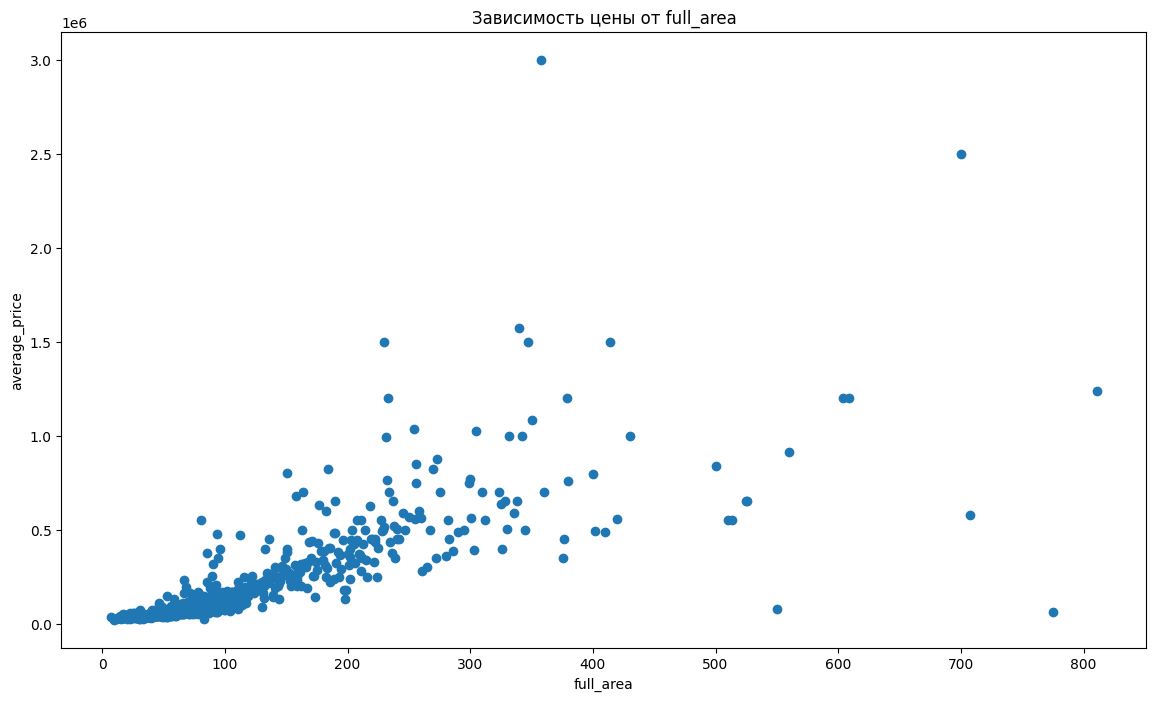

In [820]:
# Группируем данные по 'full_area' и вычисляем среднюю цену для каждой категории
mean_prices = data_new.groupby('full_area')['price'].mean()

# Создаем списки категорий критерия и значений средней цены
categories = mean_prices.index.tolist()
prices = mean_prices.values.tolist()

# Построение scatter plot
plt.subplots(figsize=(14, 8))
plt.scatter(categories, prices)
plt.xlabel('full_area')
plt.ylabel('average_price')
plt.title('Зависимость цены от full_area')

# Коэффициент корреляции для критерия 'full_area'
correlation = data_new['price'].corr(data_new['full_area'])
print(f"Коэффициент корреляции: {correlation}")

# Отображение графика
plt.show()



Коэффициент корреляции: 0.5747764201307419


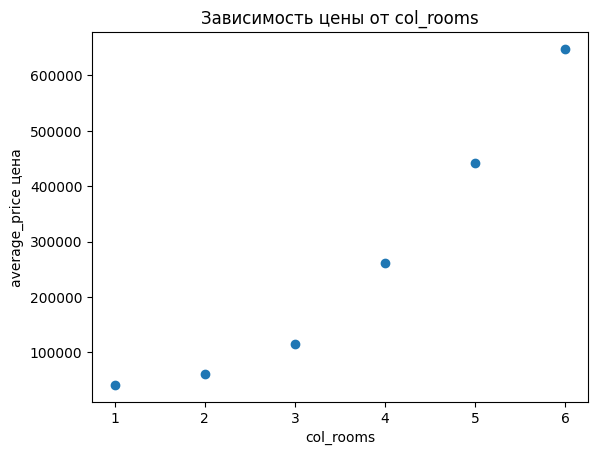

In [821]:
# Группируем данные по 'col_rooms' и вычисляем среднюю цену для каждой категории
mean_prices = data_new.groupby('col_rooms')['price'].mean()

# Создаем списки категорий критерия и значений средней цены
categories = mean_prices.index.tolist()
prices = mean_prices.values.tolist()

# Построение scatter plot
plt.scatter(categories, prices)
plt.xlabel('col_rooms')
plt.ylabel('average_price цена')
plt.title('Зависимость цены от col_rooms')

# Коэффициент корреляции для критерия 'col_rooms'
correlation = data_new['price'].corr(data_new['col_rooms'])
print(f"Коэффициент корреляции: {correlation}")

# Отображение графика
plt.show()



Коэффициент корреляции: -0.23034456744768775


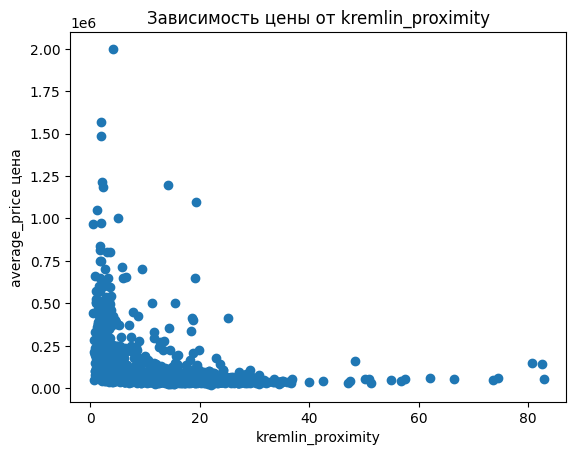

In [822]:
# Группируем данные по 'kremlin_proximity' и вычисляем среднюю цену для каждой категории
mean_prices = data_new.groupby('kremlin_proximity')['price'].mean()

# Создаем списки категорий критерия и значений средней цены
categories = mean_prices.index.tolist()
prices = mean_prices.values.tolist()

# Построение scatter plot
plt.scatter(categories, prices)
plt.xlabel('kremlin_proximity')
plt.ylabel('average_price цена')
plt.title('Зависимость цены от kremlin_proximity')

# Коэффициент корреляции для критерия 'kremlin_proximity'
correlation = data_new['price'].corr(data_new['kremlin_proximity'])
print(f"Коэффициент корреляции: {correlation}")

# Отображение графика
plt.show()


Коэффициент корреляции: 0.6193235615540086


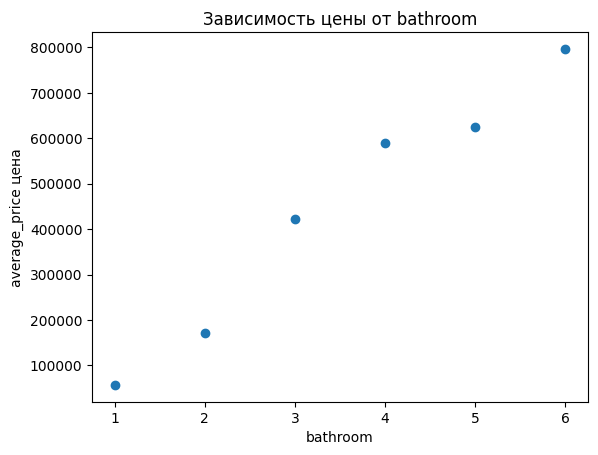

In [823]:
# Группируем данные по 'bathroom' и вычисляем среднюю цену для каждой категории
mean_prices = data_new.groupby('bathroom')['price'].mean()

# Создаем списки категорий критерия и значений средней цены
categories = mean_prices.index.tolist()
prices = mean_prices.values.tolist()

# Построение scatter plot
plt.scatter(categories, prices)
plt.xlabel('bathroom')
plt.ylabel('average_price цена')
plt.title('Зависимость цены от bathroom')

# Коэффициент корреляции для критерия 'bathroom'
correlation = data_new['price'].corr(data_new['bathroom'])
print(f"Коэффициент корреляции: {correlation}")

# Отображение графика
plt.show()


<Axes: >

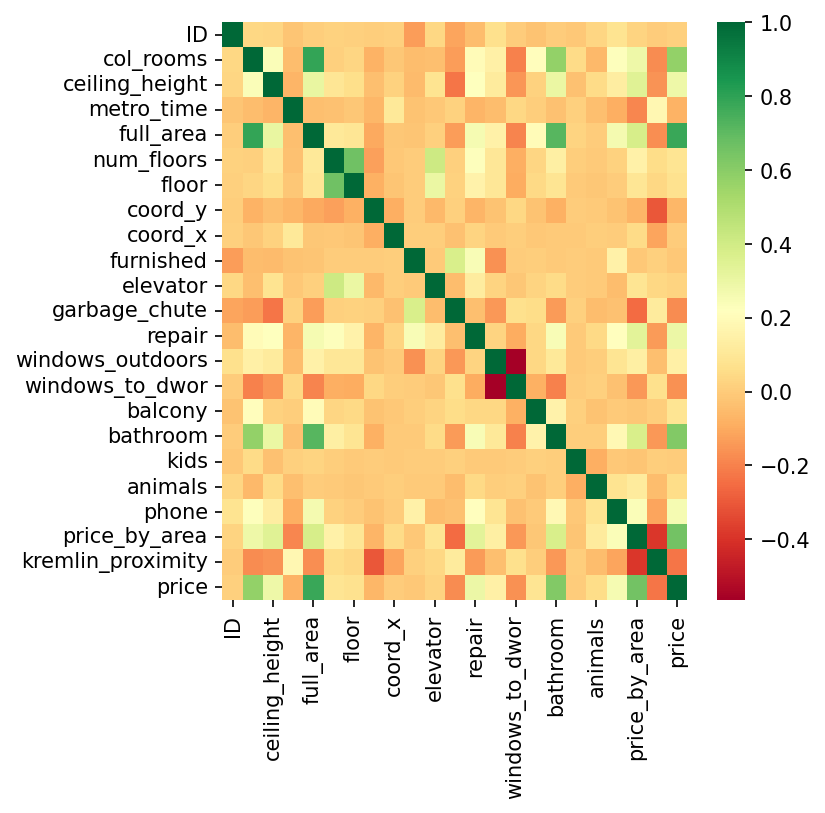

In [824]:
plt.figure(figsize=(5, 5), dpi=150)
sns.heatmap(data_new.corr(),cmap='RdYlGn')

In [825]:
data_new=pd.concat([data_new, pd.get_dummies(data_new['repair'], prefix='repair_').applymap(lambda x: {True:1,False:0}[x])], axis=1)

data_new=pd.concat([data_new, pd.get_dummies(data_new['repair'], prefix='repair_for_area').applymap(lambda x: {True:1,False:0}[x])], axis=1)
#data_new['repair_for_area_0']=data_new['repair_for_area_0']*data_new['full_area']
data_new['repair_for_area_1']=data_new['repair_for_area_1']*data_new['full_area']
data_new['repair_for_area_2']=data_new['repair_for_area_2']*data_new['full_area']
data_new['repair_for_area_3']=data_new['repair_for_area_3']*data_new['full_area']


#мы посчитали, что столбец price_by_area нечестный, особенно в случаях когда на конкретной улице мало квартир
data_new=data_new.drop(['repair','price_by_area'],axis=1)

In [826]:
data_new

,ID,col_rooms,ceiling_height,metro_time,full_area,num_floors,floor,coord_y,coord_x,furnished,elevator,garbage_chute,windows_outdoors,windows_to_dwor,balcony,bathroom,kids,animals,phone,kremlin_proximity,price,repair__0,repair__1,repair__2,repair__3,repair_for_area_0,repair_for_area_1,repair_for_area_2,repair_for_area_3
0,271271157,4,3.0,9.0,200.0,16.0,5.0,37.601065,55.752996,1,5,1,1,1,1,1,1,1,3.700440,1.855567,500000,0,0,0,1,0,0.0,0.0,200.0
1,272197456,4,3.2,3.0,170.0,6.0,5.0,37.588459,55.746600,1,1,0,1,0,1,3,0,1,3.321928,3.289740,400000,0,0,1,0,0,0.0,170.0,0.0
2,273614615,2,3.9,7.0,58.0,26.0,12.0,37.601065,55.752996,1,2,1,1,0,1,2,1,1,4.523562,1.855567,225000,0,0,1,0,0,0.0,58.0,0.0
3,274837728,3,2.8,5.0,92.0,7.0,3.0,37.580064,55.748857,1,2,0,1,1,1,1,1,1,4.000000,4.197794,470000,0,0,0,1,0,0.0,0.0,92.0
4,273643908,5,3.2,4.0,213.0,5.0,4.0,37.608226,55.754061,1,1,0,1,0,1,2,1,1,3.459432,1.072712,350000,0,0,1,0,0,0.0,213.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17907,215565511,1,2.8,8.0,35.0,14.0,10.0,37.370423,55.647751,1,2,0,1,1,1,1,1,1,0.000000,28.996974,42000,0,0,1,0,0,0.0,35.0,0.0
17908,274654844,1,2.8,7.0,38.7,18.0,5.0,37.118064,55.587787,1,2,0,0,1,1,1,1,1,0.000000,57.424617,45000,0,0,1,0,0,0.0,38.7,0.0
17909,268679909,2,2.8,6.0,43.1,5.0,5.0,37.390800,55.654882,0,2,0,1,0,1,1,1,0,0.000000,26.648439,50000,0,0,0,1,0,0.0,0.0,43.1
17910,274807525,2,2.6,11.0,52.5,23.0,8.0,37.398719,55.655718,1,3,1,0,1,1,2,1,1,0.000000,25.791628,55000,0,0,1,0,0,0.0,52.5,0.0


In [827]:
#удаляем выбросы по цене, выяснить, почему богачи ставят такие цены подобными методами вряд ли возможно
data_new=data_new[data_new['price']<400000]

In [828]:
data_new.to_csv('data.csv', encoding='utf-8')